# Calculating observables from images + simple geometric component using SPARCO

In [1]:
from collections.abc import Iterable, Iterator
from pathlib import Path
from typing import Literal

import albumentations as albs
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as nr
from jax.scipy.interpolate import RegularGridInterpolator
from scipy.ndimage import gaussian_filter

%matplotlib widget

In [2]:
# --- angular quantities ---
RAD2DEG = 180 / np.pi
DEG2MIN = 60
MIN2SEC = 60
SEC2MAS = 1000
RAD2MIN = RAD2DEG * DEG2MIN
RAD2SEC = RAD2MIN * MIN2SEC
RAD2MAS = RAD2SEC * SEC2MAS
DEG2SEC = DEG2MIN * MIN2SEC
DEG2MAS = DEG2SEC * SEC2MAS
MIN2MAS = MIN2SEC * SEC2MAS

DEG2RAD = 1 / RAD2DEG
MIN2DEG = 1 / DEG2MIN
SEC2MIN = 1 / MIN2SEC
MAS2SEC = 1 / SEC2MAS
MIN2RAD = 1 / RAD2MIN
SEC2RAD = 1 / RAD2SEC
MAS2RAD = 1 / RAD2MAS
SEC2DEG = 1 / DEG2SEC
MAS2DEG = 1 / DEG2MAS
MAS2MIN = 1 / MIN2MAS

# --- wavelengths and frequencies ---
M2MICRON = 10e6
MICRON2M = 1 / M2MICRON

## Geometric components

In [3]:
class PointSource(eqx.Module):
    r"""A point source.

    **Attributes**

    - `x`: The $x$-position of the source in $\mathrm{mas}$.
    - `y`: The $y$-position of the source in $\mathrm{mas}$.
    - `sp_idx`: The spectral index $F_lambda \propto \lamba^\mathrm{sp_idx}$
        of the source.

    The attributes can be initialised as either JAX arrays, in which case they are free
    to be optimised, or floats, in which they are considered static."""

    x: jax.Array | float
    y: jax.Array | float
    sp_idx: jax.Array | float

    def __init__(
        self,
        *,
        x: jax.Array | float = 0.0,
        y: jax.Array | float = 0.0,
        sp_idx: jax.Array | float = 0.0,
    ) -> None:
        """Mapped directly to class attributes, please see the class docstring."""
        self.x = x
        self.y = y
        self.sp_idx = sp_idx

    def get_complex_visibilities(self, u: jax.Array, v: jax.Array) -> jax.Array:
        r"""Compute complex visibilities.

        **Arguments**

        - `u`: 1D array of $u$-coordinates in the Fourier plane in $\mathrm{rad^{-1}}$.
        - `v`: 1D array of $v$-coordinates in the Fourier plane in $\mathrm{rad^{-1}}$.

        **Returns**

        A complex 1D array holding the complex visibilities calculated at the specified
        $uv$-coordinates.
        """
        vis = jnp.exp(-2j * jnp.pi * (u * self.x + v * self.y))
        return vis

In [4]:
class UD(eqx.Module):
    r"""A uniform dis.

    **Attributes**

    - `x`: The $x$-position of the source in $\mathrm{mas}$.
    - `y`: The $y$-position of the source in $\mathrm{mas}$.
    - `ud`:  The angular uniform disk size in $\mathrm{mas}$.
    - `sp_idx`: The spectral index $F_lambda \propto \lamba^\mathrm{sp_idx}$
        of the source.

    The attributes can be initialised as either JAX arrays, in which case they are free
    to be optimised, or floats, in which they are considered static."""

    x: jax.Array | float
    y: jax.Array | float
    ud: jax.Array | float
    sp_idx: jax.Array | float

    def __init__(
        self,
        *,
        x: jax.Array | float = 0.0,
        y: jax.Array | float = 0.0,
        ud: jax.Array | float,
        sp_idx: jax.Array | float = 0.0,
    ) -> None:
        """Mapped directly to class attributes, please see the class docstring."""
        self.x = x
        self.y = y
        self.ud = ud
        self.sp_idx = sp_idx

    def get_complex_visibilities(self, u: jax.Array, v: jax.Array) -> jax.Array:
        r"""Compute complex visibilities.

        **Arguments**

        - `u`: 1D array of $u$-coordinates in the Fourier plane in $\mathrm{rad^{-1}}$.
        - `v`: 1D array of $v$-coordinates in the Fourier plane in $\mathrm{rad^{-1}}$.

        **Returns**

        A complex 1D array holding the complex visibilities calculated at the specified
        $uv$-coordinates.
        """
        # TODO: implement
        raise NotImplementedError

## FFT on a 2D image array

In [5]:
@jax.jit(static_argnames=["ps", "padding"])
def img_get_complex_visibilities(
    img: jax.Array,
    u: jax.Array,
    v: jax.Array,
    *,
    ps: float,
    padding: tuple[int, int] | None = None,
):
    r"""Uses FFT to calculate complex visibilities for an input 2D image.

    The FFT values are mapped onto the reqauired $uv$-coordinates using bilinear
    interpolation.

    **Arguments**

    - `img`: The 2D input image array.
    - `u`: 1D array of $u$-coordinates in the Fourier plane in $\mathrm{rad^{-1}}$.
    - `v`: 1D array of $u$-coordinates in the Fourier plane in $\mathrm{rad^{-1}}$.
    - `ps`: Pixelscale of the image in $\mathrm{rad^{-1}}$.
    - `padding`: Amount of pixels to which the image should be zero-padded before
        performing the FFT. I.e. `padding = (1024, 512)` will pad the image to
        1024 and 512 in the $x$ and $y$ direction respectively. Note the padding will
        only be applied in the respective direction if the padded size is larger than
        the original size.

    **Returns**

    A complex 1D array holding the complex visibilities calculated at the specified
    $uv$-coordinates."""

    # NOTE: take care with the dimension axis convention of numpy versus that of optical
    # interferometry. For numpy, the y direction is the first, the x direction is the
    # second.
    nx, ny = img.shape[1], img.shape[0]  # number of pixels

    if padding is None:
        npad_x, npad_y = 0, 0
    else:
        npad_x = 0 if (padding[0] - nx < 0) else padding[0] - nx
        npad_y = 0 if (padding[1] - ny < 0) else padding[1] - ny

    # Zero-pad the image.

    # NOTE: for uneven amount of padding pixels to be added, the excess pixels will be
    # added at the end of the array axes.
    img_padded = jnp.pad(
        img,
        pad_width=(
            (npad_y // 2, (npad_y // 2) + npad_y % 2),
            (npad_x // 2, (npad_x // 2) + npad_x % 2),
        ),
        mode="constant",
        constant_values=0.0,
    )

    # Perform FFT.

    # Numpy FFT frequencies are in cycles per unit of input spacing.
    # NOTE: pixelscale must be mapped to radian to get spatial frequencies in rad^-1
    nx_padded = img_padded.shape[1]
    ny_padded = img_padded.shape[0]
    u_grid = np.fft.fftshift(np.fft.fftfreq(nx_padded, d=ps))
    v_grid = np.fft.fftshift(np.fft.fftfreq(ny_padded, d=ps))

    # NOTE: due to the numpy conventions (which assumes the phase-center is at the top-
    # left of the image), you must first shift the image in order to get the phase-
    # center to be defined.
    img_shifted = jnp.fft.ifftshift(img_padded)  # Shift phase center to image center.
    fft_img = jnp.fft.fftshift(
        jnp.fft.fft2(img_shifted)
    )  # Shift frequencies to be centered.

    # NOTE: for the scipy interpolator, JAX has no out-of-bounds error, adding NaNs
    # instead. Before running this function, user should check beforehand if all
    # the uv-points will be covered.
    interpolator = RegularGridInterpolator(
        (v_grid, u_grid),
        fft_img,
    )

    points = jnp.column_stack((v, u))
    vis = interpolator(points)

    return vis

In [6]:
@jax.jit(static_argnames="ps")
def img_get_sky_coordinates(img: jax.Array, *, ps: float):
    r"""Calculate the interferometric sky coordinates from a 2D image. Note that this
    returns the coordinates of the centers of the pixels, not of the edges.

    **Arguments**

    - `img`: The image to calculate coordinates for. Should be a 2D image.
    - `ps`: The pixelscale of the image in $\mathrm{mas}$.

    **Returns**

    - `x`: A 1D array with the x-coordinates in $\mathrm{mas}$.
    - `y`: A 1D array with the x-coordinates in $\mathrm{mas}$."""

    # NOTE: take care with the dimension axis convention of numpy versus that of optical
    # interferometry. For numpy, the y direction is the first index, the x direction
    # the second.
    nx, ny = img.shape[1], img.shape[0]  # number of pixels

    # Calculate on-sky coordinates of pixel centers.

    # NOTE: take care with the coordinate convention of optical interferometry. The
    # x-coordinate is defined from right to left in the image (from west to east), and
    # the y-coordinate from bottom to top (south to north).
    # Pixel indices
    j = jnp.arange(nx)
    i = jnp.arange(ny)

    x = -(j - (nx - 1) / 2) * ps
    y = ((ny - 1) / 2 - i) * ps

    return x, y

In [7]:
def fft_img_get_uv_coordinates(img: jax.Array, ps: float):
    raise NotImplementedError

### Test with example radiative transfer model from training set from `data_loader.ipynb`

In [8]:
class TrainingImgLoader:
    """Data loader for loading, enhancing and serving training images. The class itself
    is an Iterable, meaning it can be iterated over in for loops. The images are
    stored on the host, and only moved to the JAX devices when a batch is served. The
    JAX arrays containing the images are 4D, using (Batch, Y, X, Channel) index
    ordering.

    For example, for a given number of batches `nbatch`, and an instance of this class
    `loader`, you can iterate over batches of JAX arrays `batch`  using
    `for step, batch in zip(range(nbatch), loader):`."""

    # Required instance attributes.
    _arrays: np.ndarray
    _batch_size: int
    _normalize: bool
    _zoomf: tuple[float, float] | None
    _bkgf: tuple[float, float] | None
    _pbkg: float
    _blur: float | None
    _rotate: bool
    _fliph: bool
    _flipv: bool
    _albs_transform: albs.Compose | None
    _seed: int | None

    # Class attributes.
    _ALLOWED_READ_MODES: tuple[str, ...] = ("NUMPY",)

    def __init__(
        self,
        files: Iterable[Path | str],
        *,
        batch_size: int,
        normalize: bool = True,
        zoomf: tuple[float, float] | None = None,
        bkgf: tuple[float, float] | None = None,
        pbkg: float = 1.0,
        blur: float | None = None,
        rotate: bool = True,
        fliph: bool = True,
        flipv: bool = True,
        seed: int | None = None,
        read_mode: Literal["NUMPY"] = "NUMPY",
    ) -> None:
        r"""**Arguments**

        - `batch_size`: Size of batches to return.
        - `normalize`: Whether to normalize images to the signed unit interval
            $[-1, 1]$.
        - `files`: Sequence of filepaths to images stored on disk.
        - `zoomf`: Range of factor to randomly zoom the images in by. Negative factors
            correspond to zooming out, postive factors to zooming in (e.g. `- 0.1`)
            corresponds to a 10% zoom-out.
        - `bkgf`: Range of factor of contribution for an additional background flux
            component. If set, an additional uniform flux level will be added to each
            pixel, such that the sum of this additional component accounts for
            `bkgf * 100` percent of the total final image flux. Defaults to None, in
            which case no background flux will be added.
        - `pbkg`: Probability of adding an overresolved flux contribution to the batched
            images. This defaults to a value of 1.0 (i.e. 100%).
        - `blur`: Standard deviation by which to convolve the original images using a
            Gaussian kernel. Can be useful for smoothing out edge/noise artefacts from
            training images. This convolution is applied when loading in the original
            images, i.e. before any other augmentation.
        - `rotate`: Randomly rotate input images.
        - `fliph`: Randomly flip images horizontally.
        - `flipv`: Randomly flip images vertically.
        - `seed`: RNG seed to be used in all randomisation of data augmentations,
            including those handled by numpy and by albumentations. Setting this
            seed will cause the batches of images produced by the object to be
            deterministic each time.
        - `read_mode`: How to interpret image files stored on disk. E.g. `NUMPY` to read
            serialized Numpy arrays in .npy files."""
        # Direct initialisation.
        self._batch_size = batch_size
        self._normalize = normalize
        self._zoomf = zoomf
        self._bkgf = bkgf
        self._pbkg = pbkg
        self._rotate = rotate
        self._blur = blur
        self._fliph, self._flipv = fliph, flipv
        self._seed = seed

        # Validate read mode
        if read_mode not in self._ALLOWED_READ_MODES:
            raise ValueError(
                f"Read method {read_mode} is not supported."
                f"Supported options are: {', '.join(self._ALLOWED_READ_MODES)}"
            )

        # Initialise albumentation transformations.
        self._set_albumentation_transform(seed=self._seed)

        # Reading in arrays (3D array shape ->  (Y, X, Channel) index ordering).
        files = [Path(file) for file in files]  #  Cast to Path if needed.
        img_list = []
        img_shape = None
        for file in files:
            img = self._read_img(file, read_mode)
            img_list.append(img)
            if (np.shape(img) != img_shape) and (img_shape is not None):
                raise ValueError(
                    f"Inconsistent shape of the current image: {np.shape(img)}."
                    f"The previous image's shape is: {img_shape}."
                )
            else:
                img_shape = np.shape(img)

        # Blur all the images in the (mutable) list.
        if self._blur is not None:
            img_list = self._blur_image_list(img_list)

        # Assign image arrays (4D array -> (Batch, Y, X, Channel) index ordering).
        # NOTE: these arrays are still stored on the host as numpy arrays. The move to
        # the JAX device is performed per batch.
        self._arrays = np.stack(img_list, axis=0)

    @staticmethod
    def _read_img(file: Path, read_mode: str) -> np.ndarray:
        """Master method to load in an image from a file stored on disk. The array
        should have a 3D shape, with (Y, X, Channel) index ordering."""
        if read_mode == "NUMPY":
            img = TrainingImgLoader._read_img_numpy(file)
        else:
            raise ValueError(f"Read mode {read_mode} is not supported.")
        if img.ndim != 3:
            raise ValueError(
                "Loaded images should have 3D shape (index ordering -> Y, X, Channel)."
                f"Instead found number of dimensions {img.ndim} for file {file}."
            )
        return img

    @staticmethod
    def _read_img_numpy(file: Path) -> np.ndarray:
        """Read in a numpy image array stored on disk."""
        img = None
        with open(file, "rb") as f:
            img = np.load(f)
        return img

    def _blur_image_list(self, array_list: list[np.ndarray]) -> list[np.ndarray]:
        """Take in a list of 3D numpy array images, and blur them with a Gaussian
        kernel of the appropriate size of pixels. The individual image arrays should
        have a 3D shape, with (Y, X, Channel) index ordering. Blurring is performed
        in-place."""
        for arr in array_list:
            for i in range(np.shape(arr)[2]):
                gaussian_filter(
                    arr[:, :, i], (self._blur, self._blur), output=arr[:, :, i]
                )  # Convolve channels in-place
        return array_list

    @staticmethod
    def _map_from_unit_signed_to_unit_interval(img_arr: np.ndarray) -> np.ndarray:
        r"""Map an image array defined in the signed unit interval $[-1, 1]$ to
        the unsigned unit interval $[0, 1]$ (0 is meant to indicate zero flux, and 1
        meant to indicate maximum flux in the image)."""
        return (img_arr + 1) / 2

    @staticmethod
    def _map_from_unit_to_unit_signed_interval(img_arr: np.ndarray) -> np.ndarray:
        r"""Map an image array defined in the unsigned unit interval $[0, 1]$ to
        the signed unit interval $[-1, 1]$ (-1 is meant to indicate zero flux, and 1
        meant to indicate maximum flux in the image)."""
        return (img_arr * 2) - 1

    def __iter__(self) -> Iterator[jax.Array]:
        """Returns a generator which yields batches of images as a JAX array.

        **Returns:**

        A generator yielding 4D JAX arrays containing the images, using (Batch, Y, X,
        Channel) index ordering. The batched images are enhanced according to the
        various attributes set in the `TrainingImgLoader` instance."""
        dataset_size = self._arrays.shape[0]

        # Numpy RNG generator for batch enhancement.
        rng_gen = nr.default_rng(seed=self._seed)

        # Keep continuously feeding epochs.
        idxs = np.arange(dataset_size)
        while True:
            perm_idxs = rng_gen.permutation(idxs)  # Permute dataset indices.

            # Loop over batches in single epoch.
            start = 0
            end = self._batch_size
            while end < dataset_size:
                batch_idxs = perm_idxs[start:end]  # Image indices for current batch.
                img_batch = np.copy(self._arrays[batch_idxs])  # Make a deep copy.
                # Note that the batch enhancement should be thought of as a function
                # that consumes a JAX RNG key.
                img_batch = self._enhance_batch(
                    img_batch, rng_gen=rng_gen, normalize=self._normalize
                )

                yield jnp.array(img_batch)

                start = end  # Set state for next batch.
                end = start + self._batch_size

    def _set_albumentation_transform(self, seed: int | None) -> None:
        """Sets the albumnentation transform attribute to be used during data
        enhancement."""
        transforms = []
        if self._fliph:
            transforms.append(albs.HorizontalFlip(p=0.5))
        if self._flipv:
            transforms.append(albs.VerticalFlip(p=0.5))
        if self._rotate or self._zoomf is not None:  # Affine for rotation and zoom.
            if self._rotate:
                rot_lims = (0.0, 360.0)
            else:
                rot_lims = 0.0
            if self._zoomf is not None:
                scale_lims = (1.0 + self._zoomf[0], 1.0 + self._zoomf[1])
            else:
                scale_lims = (1.0, 1.0)

            transforms.append(
                albs.Affine(
                    scale=scale_lims,
                    rotate=rot_lims,
                    interpolation=1,  # Linear interpolation (0 for nearest neighbor).
                    fit_output=False,  # Do not force fitting of tranformed image.
                    keep_ratio=True,  # Keep original aspect ratio.
                    rotate_method="largest_box",
                    balanced_scale=True,  # Ensure balanced scaling factor sampling.
                    border_mode=0,  # Fill in border with constant.
                    fill=0.0,  # Border fill constant value.
                    p=1.0,  # Always apply.
                )
            )
        if transforms == []:
            self._albs_transform = None
        else:
            self._albs_transform = albs.Compose(transforms, seed=self._seed)
        return

    def _enhance_batch(
        self, img_batch: np.ndarray, *, rng_gen: nr.Generator, normalize: bool
    ) -> np.ndarray:
        """Enhance a batch of images, passed along as a 4D numpy array (index ordering
        -> Batch, Y, X, Channel). Enhancement is performed in-place. It uses a numpy
        RNG generator to perform any random operations needed."""
        # Loop over 3D images in batch.
        nbatch = np.shape(img_batch)[0]
        for i_img in range(nbatch):
            # Apply albumentations transform to each 3D image array (note the output of
            # Compose is a dict).
            if self._albs_transform is not None:
                img_batch[i_img, :, :, :] = self._albs_transform(
                    image=img_batch[i_img, :, :, :]
                )["image"]

        # Apply additional background flux to each channel.
        if self._bkgf is not None:
            # Uniform numbers to decide if to apply background flux.
            uniform_rand = rng_gen.uniform(size=(nbatch,))
            # Loop over 3D images in batch.
            for i_img in range(nbatch):
                if uniform_rand[i_img] < self._pbkg:
                    # If background is to be applied, randomly take background strength
                    # within limits.
                    bkg_factor = rng_gen.uniform(low=self._bkgf[0], high=self._bkgf[1])
                    # Apply to each image channel.
                    for i_ch in range(img_batch.shape[3]):
                        img_batch[i_img, :, :, i_ch] += (
                            np.max(img_batch[i_img, :, :, i_ch]) * bkg_factor
                        )

        # Apply normalization to the signed unit interval [-1, 1].
        if self._normalize:
            # Loop over 3D images in batch.
            for i_img in range(nbatch):
                for i_ch in range(img_batch.shape[3]):
                    img_batch[i_img, :, :, i_ch] /= np.max(img_batch[i_img, :, :, i_ch])
                    img_batch[i_img, :, :, i_ch] = (
                        self._map_from_unit_to_unit_signed_interval(
                            img_batch[i_img, :, :, i_ch]
                        )
                    )

        return img_batch

In [9]:
directory = """/home/toond/Documents/phd/paper_matisse_imaging/training_data/\
discs_mcfost/runs/ozstar_2zone_cont_training_set/saved_imgs"""

files = sorted(Path(directory).glob("*.npy"))

loader = TrainingImgLoader(
    files,
    batch_size=1,
    normalize=True,
    zoomf=(-0.1, 0.1),
    bkgf=(0.00, 0.10),
    pbkg=0.25,
    blur=0.5,
    rotate=True,
    fliph=True,
    flipv=True,
    read_mode="NUMPY",
    seed=42,
)

# For a generator function, have to zip (which truncates to the shortest of iterables)
# with e.g. a range to limit steps.
nbatch = 1
for step, batch in zip(range(nbatch), loader):
    img = jnp.array(
        loader._map_from_unit_signed_to_unit_interval(np.array(batch[0, :, :, 0]))
    )

#### Testing the pixel coordinate calculation

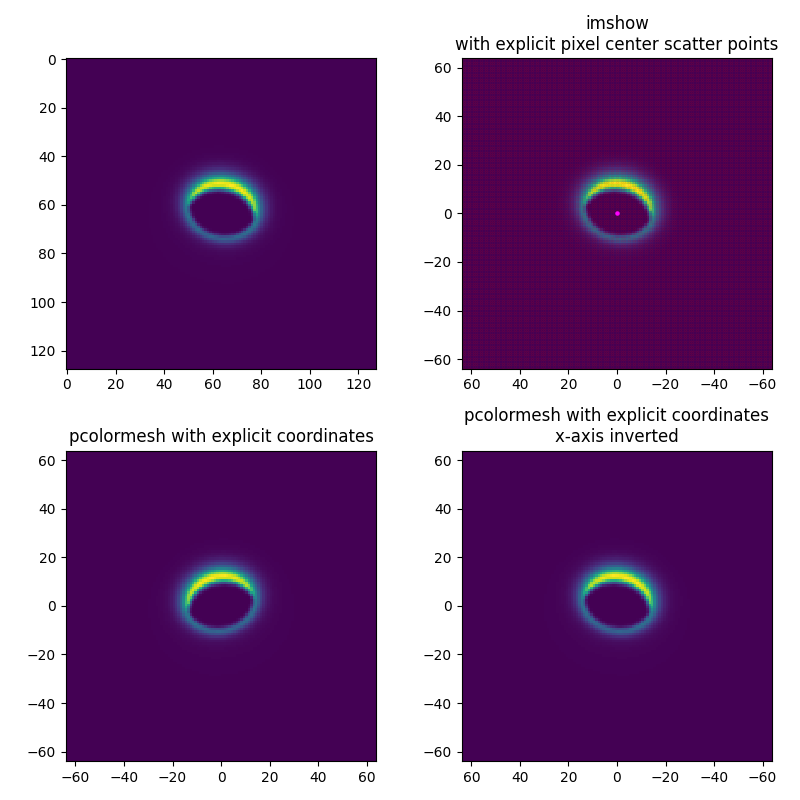

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

# Pixelscale = 1.
ps = 1

# Get sky coordinates of pixel centers.
x, y = img_get_sky_coordinates(img, ps=ps)
X, Y = jnp.meshgrid(x, y)
ax[0][0].imshow(img, interpolation="none")
ax[0][0].set_title("")

# NOTE: when plotting with coordinates, don't forget to flip the x-axis and account for
# an extra half pixelsize to the max/min coordinates (the extent keyword expects the
# edges of the image, not the centers of the edge pixels).
ax[0][1].imshow(
    img,
    interpolation="none",
    extent=[
        jnp.max(x) + ps / 2,
        jnp.min(x) - ps / 2,
        jnp.min(y) - ps / 2,
        jnp.max(y) + ps / 2,
    ],
)
ax[0][1].scatter(X, Y, c="r", s=0.1, alpha=0.2)
ax[0][1].scatter(0, 0, c="magenta", s=5)
ax[0][1].set_title("imshow\nwith explicit pixel center scatter points")

ax[1][0].pcolormesh(X, Y, img)
ax[1][0].set_aspect("equal")
ax[1][0].set_title("pcolormesh with explicit coordinates")

ax[1][1].pcolormesh(X, Y, img)
ax[1][1].set_aspect("equal")
ax[1][1].invert_xaxis()
ax[1][1].set_title("pcolormesh with explicit coordinates\nx-axis inverted")

plt.tight_layout()
plt.show()

#### Testing application of the FFT

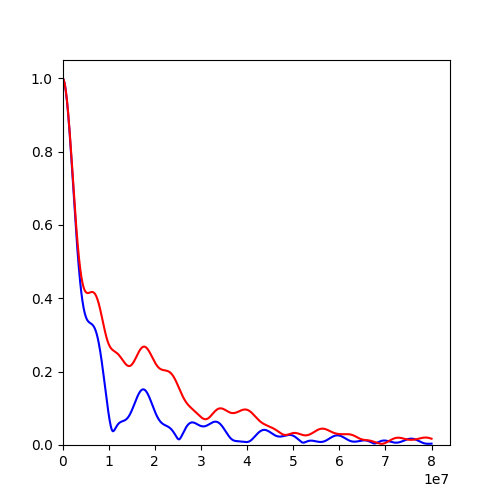

In [11]:
u_ucut = jnp.linspace(0, 80e6, 1000)
v_ucut = jnp.zeros_like(u_ucut)
vis_ucut = img_get_complex_visibilities(
    img, u_ucut, v_ucut, ps=0.5 * MAS2RAD, padding=(10_000, 10_000)
)

v_vcut = jnp.linspace(0, 80e6, 1000)
u_vcut = jnp.zeros_like(v_vcut)
vis_vcut = img_get_complex_visibilities(
    img, u_vcut, v_vcut, ps=0.5 * MAS2RAD, padding=(10_000, 10_000)
)


fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(u_ucut, jnp.abs(vis_ucut) / jnp.sum(img), c="blue")
ax.plot(v_vcut, jnp.abs(vis_vcut) / jnp.sum(img), c="red")
ax.set_ylim(0)
ax.set_xlim(0)
plt.show()

### 

## Application to ORGANIC image reconstruction with SPARCO

In [ ]:
def ring_first_null(diameter_mas):
    """
    Compute the first null spatial frequency of a thin ring.

    Parameters
    ----------
    diameter_mas : float
        Outer diameter of the ring in milliarcseconds.

    Returns
    -------
    f_rad : float
        First null spatial frequency in cycles per radian.
    f_Mlambda : float
        First null spatial frequency in Mega-lambda (B / lambda).
    """
    # Convert outer diameter to radius in radians
    radius_mas = diameter_mas / 2
    theta_rad = radius_mas * 1e-3 / 3600 * np.pi / 180  # mas -> arcsec -> deg -> rad

    # First zero of J0
    first_zero = 2.4048

    # Spatial frequency in cycles/radian
    f_rad = first_zero / (2 * np.pi * theta_rad)

    # Convert to Mega-lambda
    f_Mlambda = f_rad / 1e6

    return f_rad, f_Mlambda

In [ ]:
def generate_ring_image(
    npix=256, diameter_mas=12.5, pixel_scale_mas=0.05, width_fraction=0.05
):
    """
    Generate a 2D image of a thin ring.

    Parameters
    ----------
    npix : int
        Number of pixels along one axis (image is square).
    diameter_mas : float
        Ring outer diameter in milliarcseconds.
    pixel_scale_mas : float
        Pixel scale in mas/pixel.
    width_fraction : float
        Fraction of the radius for the ring thickness.

    Returns
    -------
    img : np.ndarray
        2D array containing the ring image.
    """
    # Convert diameter to radius in pixels
    radius_pix = (diameter_mas / 2) / pixel_scale_mas
    width_pix = radius_pix * width_fraction

    # Coordinate grids centred at middle of image
    y, x = np.indices((npix, npix)) - npix / 2
    r = np.sqrt(x**2 + y**2)

    # Ring mask: pixels within radius ± half-width
    mask = np.logical_and(
        r >= radius_pix - width_pix / 2, r <= radius_pix + width_pix / 2
    )

    # Create image
    img = np.zeros((npix, npix), dtype=np.float32)
    img[mask] = 1.0  # Set ring intensity

    return img


# Example usage
ps = 0.1
img = generate_ring_image(
    npix=512, diameter_mas=12.5, pixel_scale_mas=ps, width_fraction=0.05
)

# Visualise
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(img)
ax.set_title("Thin Ring")
plt.show()

In [ ]:
u_ucut = jnp.linspace(0, 80e6, 1000)
v_ucut = jnp.zeros_like(u_ucut)
vis_ucut = img_get_complex_visibilities(
    img, u_ucut, v_ucut, ps=ps * MAS2RAD, padding=(10_000, 10_000)
)

v_vcut = jnp.linspace(0, 80e6, 1000)
u_vcut = jnp.zeros_like(v_vcut)
vis_vcut = img_get_complex_visibilities(
    img, u_vcut, v_vcut, ps=ps * MAS2RAD, padding=(10_000, 10_000)
)


fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(u_ucut, jnp.abs(vis_ucut) / jnp.sum(img), c="blue")
ax.plot(v_vcut, jnp.abs(vis_vcut) / jnp.sum(img), c="red")
ax.set_ylim(0)
ax.set_xlim(0)
plt.show()